<a href="https://colab.research.google.com/github/Saviour71/DeepKeyGeN/blob/main/DeepKeyGeN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
pip install nibabel


In [4]:
import os
import torch
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.utils import save_image
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sanglequang/brats2018")

print("Path to dataset files:", path)

100%|██████████| 3.18G/3.18G [00:37<00:00, 89.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sanglequang/brats2018/versions/10


In [27]:

brats18_dataset_dir = "/root/.cache/kagglehub/datasets/sanglequang/brats2018/versions/10/MICCAI_BraTS_2018_Data_Training/HGG"


In [28]:
def load_and_preprocess_nifti(file_path):
    nifti_data = nib.load(file_path)
    nifti_array = nifti_data.get_fdata()
    nifti_tensor = torch.from_numpy(nifti_array)
    return nifti_tensor


In [29]:
class BRATS18Dataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image = load_and_preprocess_nifti(self.file_paths[idx])
        return image


file_names = os.listdir(brats18_dataset_dir)
file_paths = [os.path.join(brats18_dataset_dir, f) for f in file_names]

dataset = BRATS18Dataset(file_paths)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)


In [30]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, 1, 1)
        self.conv2 = nn.Conv2d(channels, channels, 3, 1, 1)
        self.norm = nn.InstanceNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        x = self.relu(self.norm(self.conv1(x)))
        x = self.norm(self.conv2(x))
        return x + residual


In [31]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 7)
        self.norm1 = nn.InstanceNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 4, 2)
        self.norm2 = nn.InstanceNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 4, 2)
        self.norm3 = nn.InstanceNorm2d(64)
        self.res = nn.Sequential(*[ResidualBlock(64) for _ in range(6)])
        self.deconv1 = nn.ConvTranspose2d(64, 32, 4, 2)
        self.norm4 = nn.InstanceNorm2d(32)
        self.deconv2 = nn.ConvTranspose2d(32, 16, 4, 2)
        self.norm5 = nn.InstanceNorm2d(16)
        self.out = nn.Conv2d(16, 3, 7)

    def forward(self, x):
        x = torch.relu(self.norm1(self.conv1(x)))
        x = torch.relu(self.norm2(self.conv2(x)))
        x = torch.relu(self.norm3(self.conv3(x)))
        x = self.res(x)
        x = torch.relu(self.norm4(self.deconv1(x)))
        x = torch.relu(self.norm5(self.deconv2(x)))
        return torch.tanh(self.out(x))


In [32]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, 4, 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, 4, 2),
            nn.InstanceNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, 2),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 1, 4)
        )

    def forward(self, x):
        return self.model(x)


In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCEWithLogitsLoss()
opt_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [36]:
import os
import nibabel as nib
import torch
from torch.utils.data import Dataset

class BratsDataset(Dataset):
    def __init__(self, root_dir):
        self.files = []

        for root, _, filenames in os.walk(root_dir):
            for f in filenames:
                if f.endswith(".nii") or f.endswith(".nii.gz"):
                    self.files.append(os.path.join(root, f))

        if len(self.files) == 0:
            raise RuntimeError("No NIfTI files found. Check dataset path.")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        img = nib.load(img_path).get_fdata()
        return torch.tensor(img)


In [38]:
from torch.utils.data import DataLoader

dataset_path = "/root/.cache/kagglehub/datasets/sanglequang/brats2018/versions/10/MICCAI_BraTS_2018_Data_Training/HGG"

dataset = BratsDataset(dataset_path)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

print("Total MRI files:", len(dataset))


Total MRI files: 1050


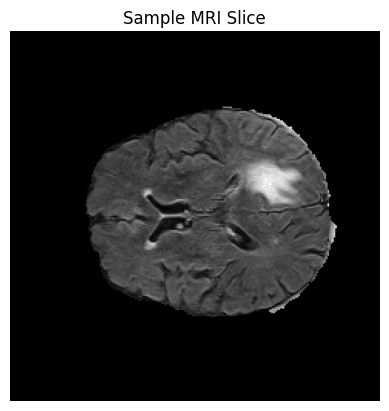

In [45]:
import matplotlib.pyplot as plt

sample = dataset[0]
slice_idx = sample.shape[2] // 2

plt.imshow(sample[:, :, slice_idx], cmap="gray")
plt.title("Sample MRI Slice")
plt.axis("off")
plt.show()


In [39]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = 5
lr = 0.0002
img_size = 256

print("Using device:", device)


Using device: cuda


In [40]:
import torch.nn.functional as F

def preprocess_mri(mri):
    # mri shape: [H, W, D]
    mri = mri[:, :, mri.shape[2] // 2]   # take middle slice
    mri = mri.unsqueeze(0).repeat(3, 1, 1)  # 3 channels
    mri = mri.unsqueeze(0)  # batch
    mri = F.interpolate(mri, size=(256,256))
    return mri


In [41]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(64, 3, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 1, 4, 2, 1)
        )

    def forward(self, x):
        return self.net(x)


In [42]:
G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCEWithLogitsLoss()
opt_G = torch.optim.Adam(G.parameters(), lr=lr)
opt_D = torch.optim.Adam(D.parameters(), lr=lr)


In [43]:
for epoch in range(epochs):
    for mri in dataloader:
        mri = mri.to(device).float()
        img = preprocess_mri(mri[0]).to(device)

        # ---------------- Train Discriminator ----------------
        real_label = torch.ones_like(D(img))
        fake_label = torch.zeros_like(D(img))

        fake_img = G(img)

        opt_D.zero_grad()
        d_real = criterion(D(img), real_label)
        d_fake = criterion(D(fake_img.detach()), fake_label)
        d_loss = d_real + d_fake
        d_loss.backward()
        opt_D.step()

        # ---------------- Train Generator ----------------
        opt_G.zero_grad()
        g_loss = criterion(D(fake_img), real_label)
        g_loss.backward()
        opt_G.step()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")


Epoch [1/5] | D Loss: 1.0991 | G Loss: 0.6705
Epoch [2/5] | D Loss: 1.0187 | G Loss: 0.8397
Epoch [3/5] | D Loss: 1.3860 | G Loss: 0.8176
Epoch [4/5] | D Loss: 1.0397 | G Loss: 0.9546
Epoch [5/5] | D Loss: 0.9991 | G Loss: 1.0168


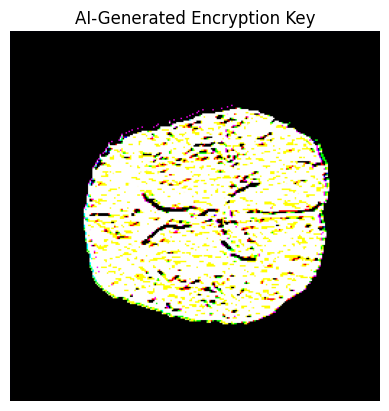

In [44]:
with torch.no_grad():
    key = G(img).cpu()

plt.imshow(key[0].permute(1,2,0))
plt.title("AI-Generated Encryption Key")
plt.axis("off")
plt.show()


In [46]:
def encrypt(img, key):
    return (img + key) % 1

def decrypt(enc, key):
    return (enc - key) % 1

encrypted = encrypt(img.cpu(), key)
decrypted = decrypt(encrypted, key)


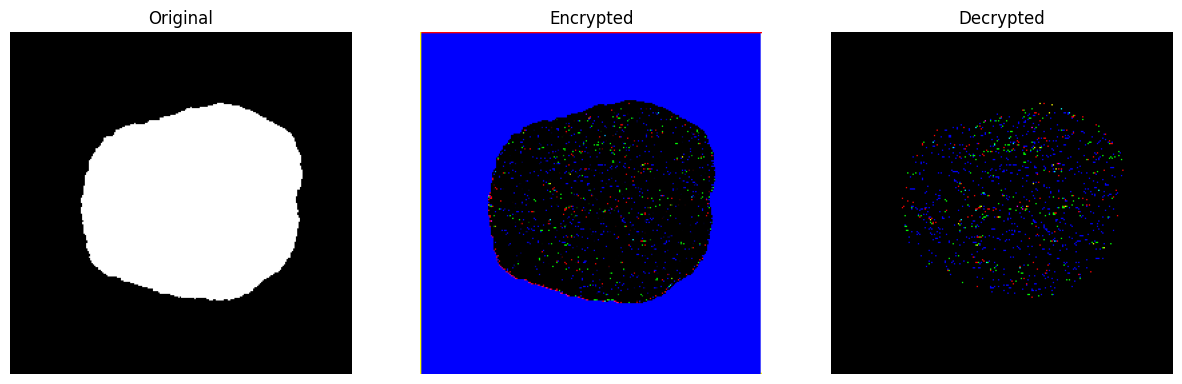

In [47]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

ax[0].imshow(img[0].permute(1,2,0).cpu(), cmap="gray")
ax[0].set_title("Original")

ax[1].imshow(encrypted[0].permute(1,2,0), cmap="gray")
ax[1].set_title("Encrypted")

ax[2].imshow(decrypted[0].permute(1,2,0), cmap="gray")
ax[2].set_title("Decrypted")

for a in ax:
    a.axis("off")

plt.show()
